In [10]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from helpers_for_plotting import diff_post, dechunk_var

s = 3 # index of the simulation we want to have a closer look on
tw_s = [10, 10, 10, 10, 20, 20, 10, 10, 10, 10, 10, 10, 10] # time window lengths in the simulated data
tw = tw_s[s] 


#----------------------------------------------------------------------------------
# Read data from different simulations into list according to invm & useKG settings
#----------------------------------------------------------------------------------

np_t = [] # list for outputs with settings. invm = numpy.linalg.inv, useKG = True
np_f = [] # invm = np.linalg.inv, useKG = False
bl_t = [] # invm = block_inv, useKG = True
bl_f = [] # invm = block_inv, useKG = False


#loop through simulations, read all but matrices from the data
for i in range(13):
    np_t.append(xr.open_mfdataset(f"simulated_data/simulation_{i:02d}/out_default_with_kf/*.nc",
                                    concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    # bl_t.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_block_with_kf/*.nc",
    #                     concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

    # np_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_default_without_kf/*.nc",
    #                                 concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))
    
    # bl_f.append(xr.open_mfdataset(f"simulated_data/simulation_0{i}/out1_block_without_kf/*.nc",
    #                                 concat_dim='time2',combine='nested', drop_variables=["prior_cov", "posterior_cov", "obs_unc"]))

# data in the chosen time window
data = np_t[s]
#------------------------------------------------------------------------------
# Had to read matrices in another way, as open_mfdataset didn't work with them
#----------------------------------------------------------------------------

def read_matrices(sim, subfilename):
    """Helper function to read output matrices from simulation instance sim.
    """
    B = [] # prior covariance matrices
    A = [] # posterior covariance matrices
    R = [] # observation error covariance matrices

    for i in range(5):
        filepath = f"simulated_data/simulation_0{sim}/{subfilename}/s0{sim}_out_0{i}.nc"
        data = xr.open_dataset(filepath)
        B.append(data["prior_cov"])
        A.append(data["posterior_cov"])
        R.append(data["obs_unc"])
    return B, A, R

Bs, As, Rs = read_matrices(s, 'out_default_with_kf')
#B_bl, A_bl, R_bl = read_matrices(s, "out_block_with_kf")

for i in range(6,9):
    print(np_t[i])

<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 500)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    posterior    (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    obs          (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    differences  (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    comments:  Fixed version of H. Matrix inverse function: inv from module: ...
<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 500)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    posterior    (ti

<xarray.Dataset>
Dimensions:      (time: 50, time2: 5, nstate: 500)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: time2, nstate
Data variables:
    prior        (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    posterior    (time2, nstate) float64 dask.array<chunksize=(1, 500), meta=np.ndarray>
    obs          (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    differences  (time2, time) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    comments:  Fixed version of H. Matrix inverse function: inv from module: ...


Posterior state
----------------

Changes so small that if I try to plot all nstates in the same plot, changes won't show, because plot will be too much zoomed out.
Better to plot one at a time as an example / sanity check

[304  11  60 217 145 204  19 367 252]


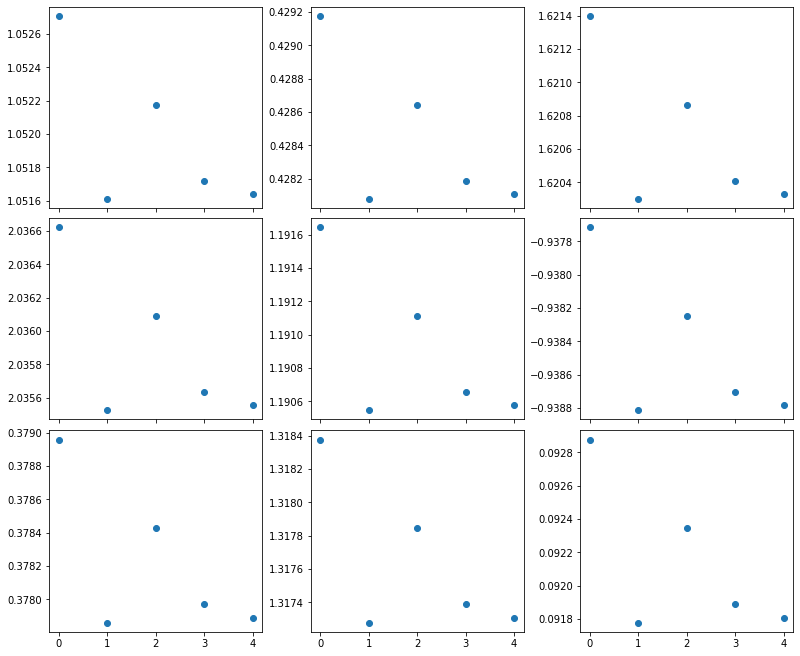

In [5]:
nstate = data.dims['nstate']
post = data.posterior

states = np.random.randint(nstate, size = 9) #pick a couple of random states to look at
print(states)
selection = []
for i in range(9):
    selection.append(post.isel(nstate = states[i]))




fig, axs = plt.subplots(3,3, figsize = (11,9), layout = 'constrained', sharex = 'col')
for k in range(9):
    i = k // 3
    j = k - 3*i
    axs[i,j].plot(selection[k], 'o') # marker = 'o', color = 'red', alpha = 0.7)
plt.show()


Observations
--------------

Text(0.5, 1.0, 'Observations (s03)')

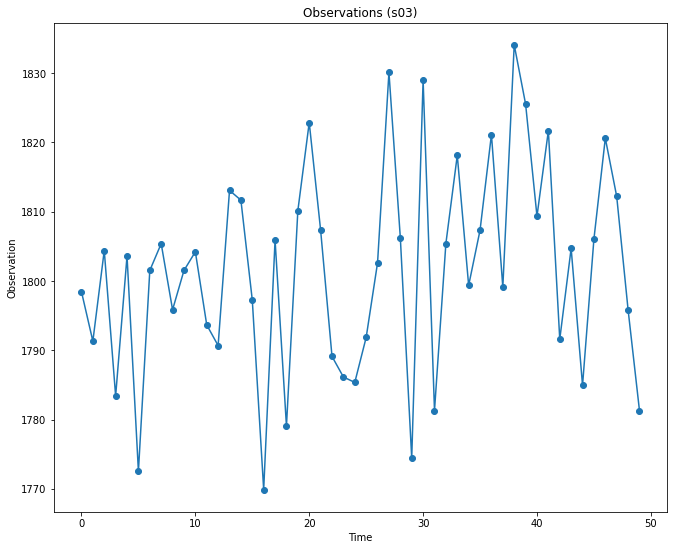

In [51]:



obs = dechunk_var(data, "obs", tw) 

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(obs, marker= 'o')
ax.set_xlabel('Time')
ax.set_ylabel('Observation')
ax.set_title(f'Observations (s0{s})')

Text(0.5, 1.0, 'Observations with alternating y_std')

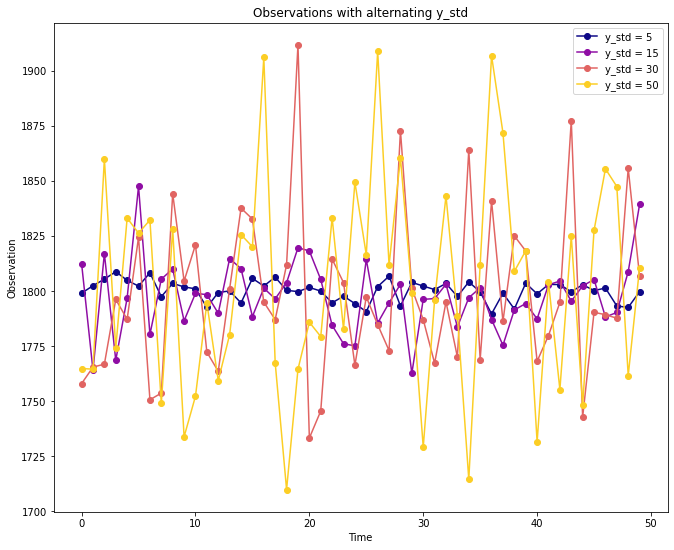

In [15]:
obss = {}
sims = [9,10,11,12]
y_stds = [5, 15, 30, 50]
# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 4))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(4):
    sim = sims[i]
    y_std = y_stds[i]
    obss[f"obs{sim}"] = dechunk_var(np_t[sim], "obs", tw_s[sim]) 
    ax.plot(obss[f"obs{sim}"], label = f"y_std = {y_std}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Observation')
ax.set_title(f'Observations with alternating y_std')


Obs - prior differences
-----------------------


Text(0.5, 1.0, 'Obs - prior differences with different y_std (nstate = 2)')

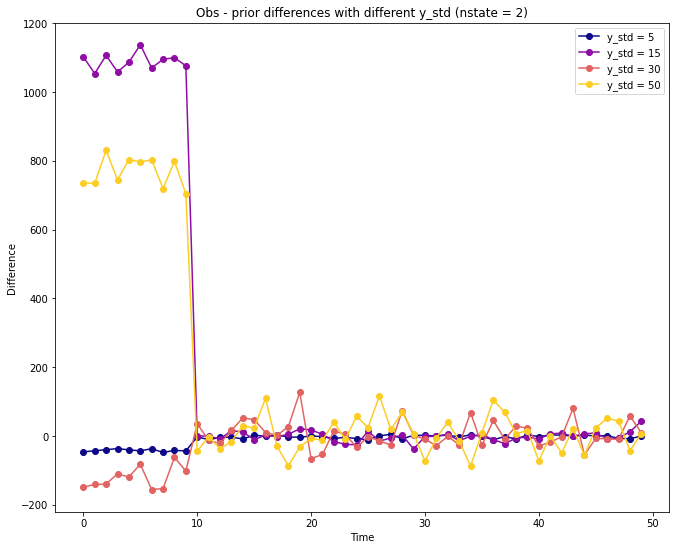

In [16]:
diff = {}

# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 4))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(4):
    sim = sims[i]
    y_std = y_stds[i]
    diff[f"diff{sim}"] = dechunk_var(np_t[sim], "differences", tw_s[sim]) 
    ax.plot(diff[f"diff{sim}"], label = f"y_std = {y_std}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Difference')
ax.set_title(f'Obs - prior differences with different y_std (nstate = 2)')

Text(0.5, 1.0, 'Obs - posterior differences with different y_std (nstate = 2)')

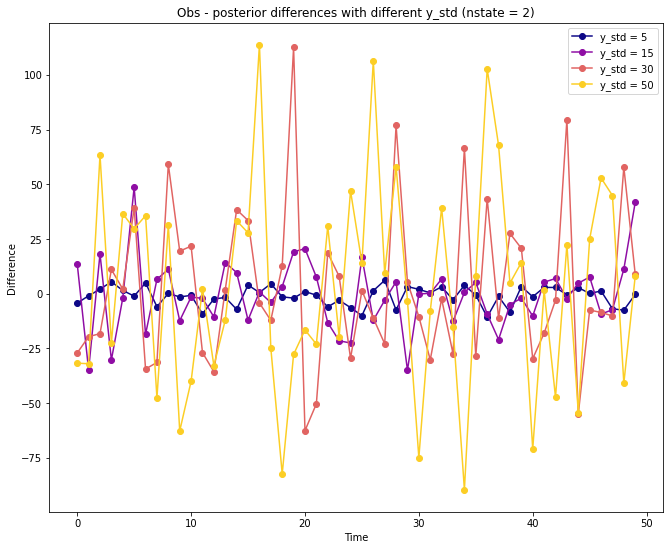

In [17]:


diff_po = {}

# create colormap
cm = plt.cm.plasma(np.linspace(0, 0.9, 4))


fig, ax = plt.subplots(figsize = (11,9))
ax.set_prop_cycle('color', list(cm))
for i in range(4):
    sim = sims[i]
    y_std = y_stds[i]
    diff_po[f"diff_po{sim}"] = diff_post(np_t[sim])
    ax.plot(diff_po[f"diff_po{sim}"], label = f"y_std = {y_std}", marker  = 'o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Difference')
ax.set_title(f'Obs - posterior differences with different y_std (nstate = 2)')

Obs - posterior differences
-----------------------------

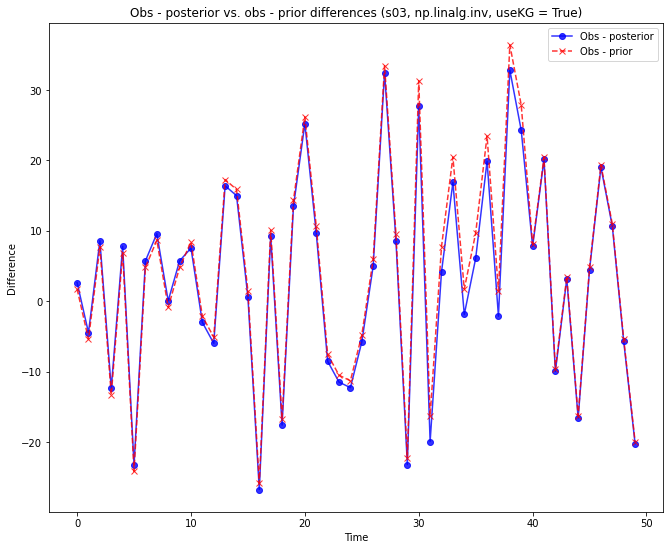

In [45]:


from helpers_for_plotting import diff_post

diff_po = diff_post(np_t[s])
diff_pr = dechunk_var(np_t[s], "differences", tw) 

fig, ax = plt.subplots(figsize = (11,9))
ax.plot(diff_po, marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
ax.plot(diff_pr, marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
ax.set_xlabel("Time")
ax.set_ylabel("Difference")
ax.legend()
ax.set_title(f"Obs - posterior vs. obs - prior differences (s0{s}, np.linalg.inv, useKG = True)")
plt.show()

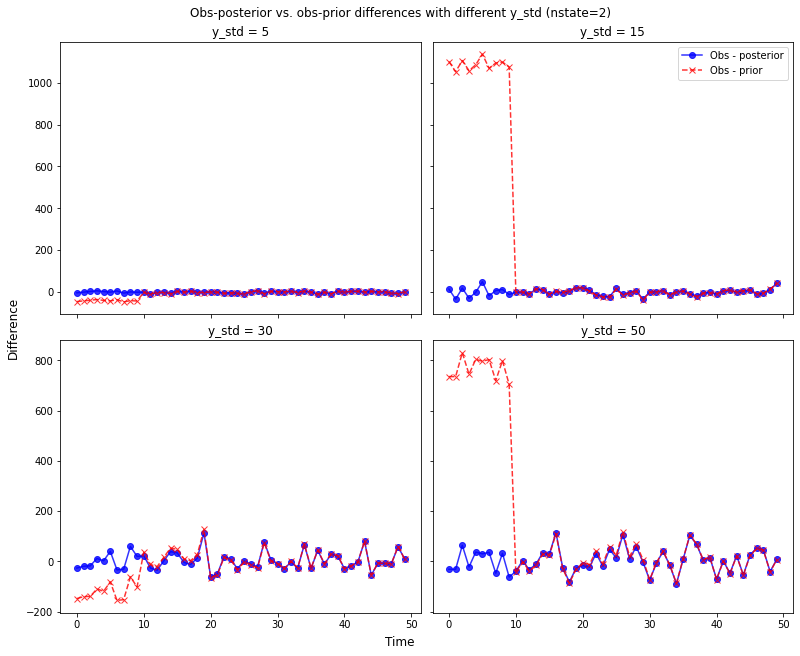

In [14]:




fig, axs = plt.subplots(2,2, figsize = (11,9), layout = 'constrained', sharex = 'col', sharey = 'row')
for k in range(4):
    i = k // 2
    j = k-2*i
    sim = sims[k]
    y_std = y_stds[k]
    diff_po = diff_post(np_t[sim])
    diff_pr = dechunk_var(np_t[sim], "differences", tw = 10)
    axs[i,j].plot(diff_po, marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
    axs[i,j].plot(diff_pr, marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
    axs[i,j].set_title(f"y_std = {y_stds[k]}")
axs[0,1].legend()
fig.supxlabel('Time')
fig.supylabel('Difference')
fig.suptitle('Obs-posterior vs. obs-prior differences with different y_std (nstate=2)')
plt.show()
 





Same, but leave out first time window

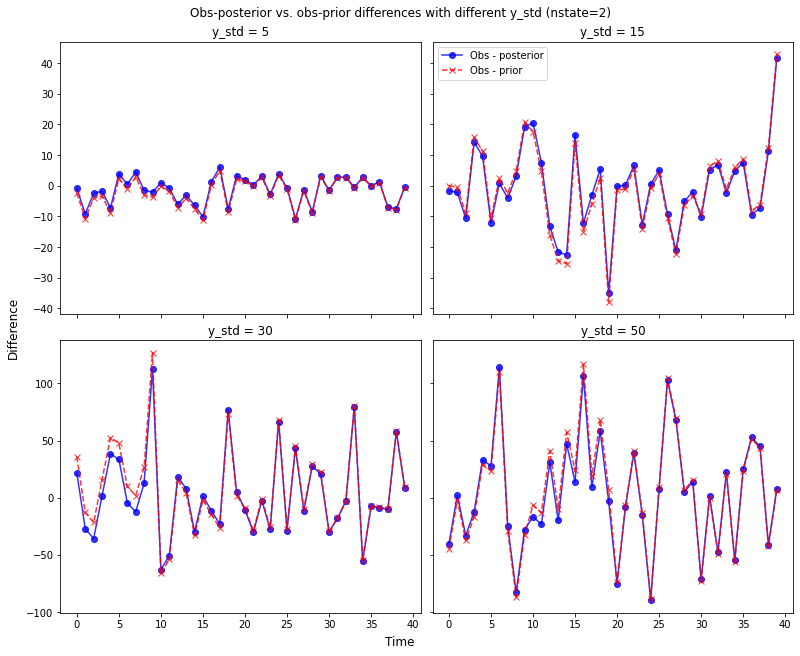

In [26]:
fig, axs = plt.subplots(2,2, figsize = (11,9), layout = 'constrained', sharex = 'col', sharey = 'row')
for k in range(4):
    i = k // 2
    j = k-2*i
    sim = sims[k]
    y_std = y_stds[k]
    diff_po = diff_post(np_t[sim])
    diff_pr = dechunk_var(np_t[sim], "differences", tw = 10)
    axs[i,j].plot(diff_po.sel(time = slice(10,50)), marker = 'o', color = 'blue', alpha = 0.8, label = "Obs - posterior")
    axs[i,j].plot(diff_pr.sel(time = slice(10,50)), marker = 'x', color = 'red', linestyle = 'dashed', alpha = 0.8, label = "Obs - prior")
    axs[i,j].set_title(f"y_std = {y_stds[k]}")
axs[0,1].legend()
fig.supxlabel('Time')
fig.supylabel('Difference')
fig.suptitle('Obs-posterior vs. obs-prior differences with different y_std (nstate=2)')
plt.show()

In [18]:
print(diff_po)
print(diff_pr)

{'diff_po9': <xarray.DataArray 'obs' (time: 50)>
dask.array<concatenate, shape=(50,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49, 'diff_po10': <xarray.DataArray 'obs' (time: 50)>
dask.array<concatenate, shape=(50,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49, 'diff_po11': <xarray.DataArray 'obs' (time: 50)>
dask.array<concatenate, shape=(50,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49, 'diff_po12': <xarray.DataArray 'obs' (time: 50)>
dask.array<concatenate, shape=(50,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49}
<xarray.DataArray 'differences' (time: 50)>
dask.arr

Covariance and observation uncertainty matrices
------------------------------------------------

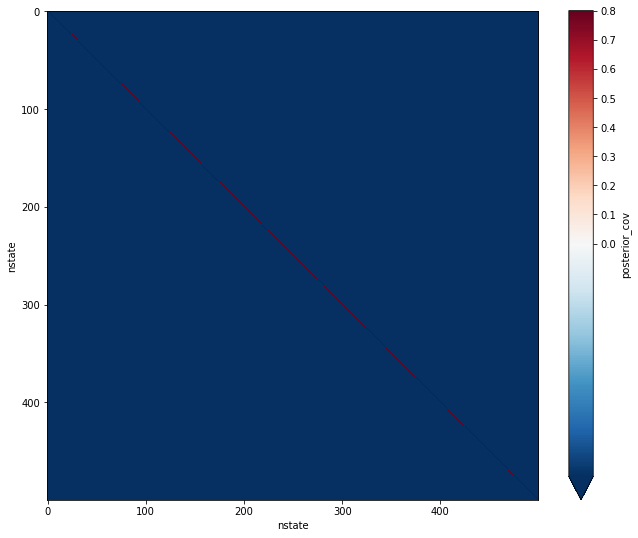

In [56]:
M = A[4]

qlower = np.quantile(M, 0.01)
qupper = np.quantile(M, 0.99)

fig, ax = plt.subplots(figsize = (11,9))
norm = colors.TwoSlopeNorm(vmin = min(0,qlower), vcenter = 0, vmax = max(0.8,qupper))
M.plot.imshow(ax=ax, yincrease = False, norm = norm)
plt.show()


Multiple subplots in same figure

* turns out the colorbar normalation is tricky


The easiest but ugliest way out: each subplot has its own colorbar, and colorbar ranges differ.


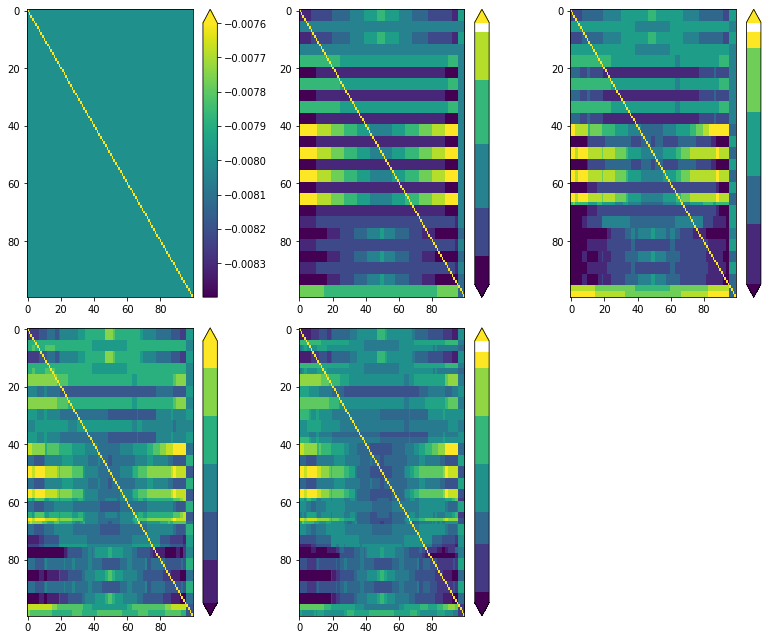

In [ ]:

fig, axs = plt.subplots(2,3, figsize = (11,9))
axs[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    A_np[k].plot.imshow(ax = axs[i,j], yincrease = False, add_labels = False, robust = True)
plt.tight_layout()
plt.show()



QUANTILES + SYMLOGNORM

Problem with SymLogNorm: plots a really nice plot but the colormap doesn't center at zero

Colorbar min and max set manually to certain quantiles.
Alfa has to be really small < 10**(-3) 
Otherwise all but the first subplot seem to become uniformly one color
because such an immense part of the values within very small range around zero


-0.001599907412765469 0.7984004628290428


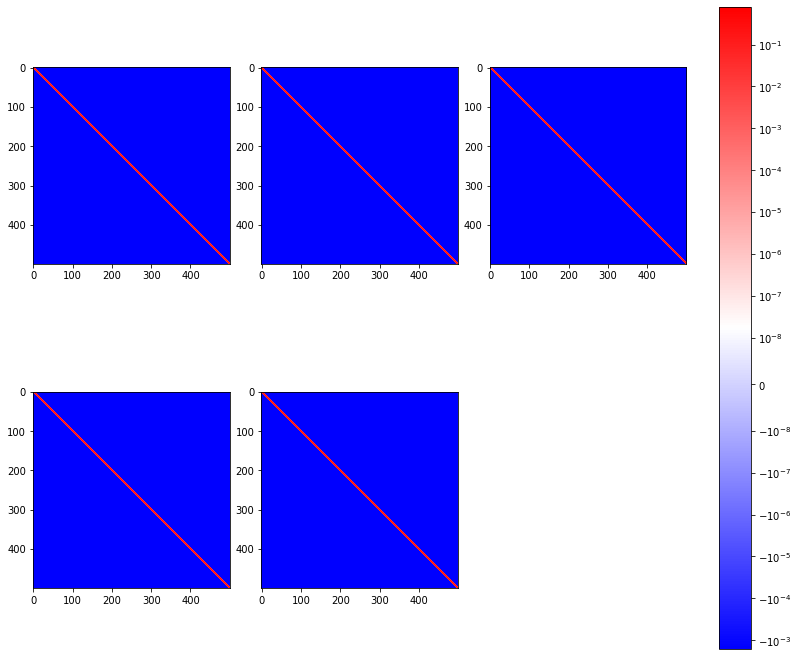

In [8]:

qlower = min(np.quantile(A.values, 0.001) for A in As)
qupper = max(np.quantile(A.values, 0.999) for A in As)
vmin = min(A.values.min() for A in As)
vmax = max(A.values.max() for A in As)
print(qlower, qupper)

fig, axs = plt.subplots(2,3, figsize = (11,9), layout = 'constrained')
axs[-1,-1].axis('off')

images = []
for k in range(5):
    i = k // 3
    j = k - 3*i
    images.append(axs[i,j].imshow(As[k], cmap = 'bwr'))
    #axs[i, j].label_outer()

#norm = colors.TwoSlopeNorm(vcenter = 0.0, vmin = qlower, vmax = qupper)

from normalize_midpoint import MidpointNormalize
#norm = MidpointNormalize(vmin=qlower, vmax=qupper, midpoint=0)
norm = colors.SymLogNorm(vmin=qlower, vmax = qupper, linthresh = 10**(-8))
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm)
plt.show()



From stackexchange: 

This is for the more complex case where the values are not just between 0 and 1; the cmap needs to be shared instead of just using the last one.


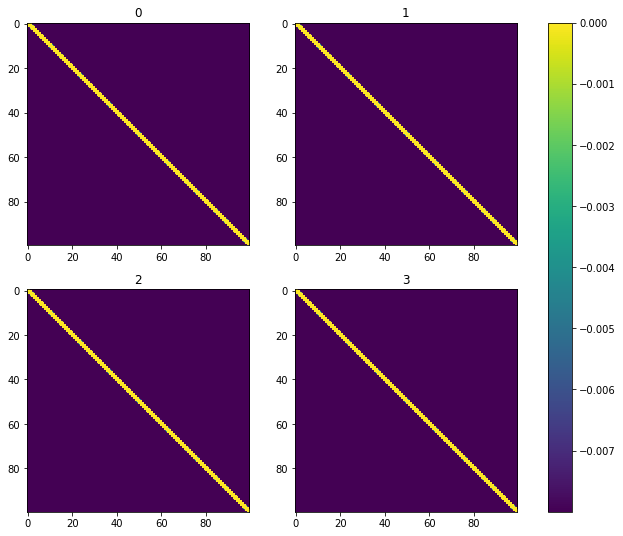

In [ ]:



import matplotlib.cm as cm
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (11, 9))
cmap=cm.get_cmap('viridis')
normalizer=colors.Normalize(qlower, qupper)
im=cm.ScalarMappable(norm=normalizer, cmap = cmap)
for i,ax in enumerate(axes.flat):
    ax.imshow(A_np[i],cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Another one from stackexchange

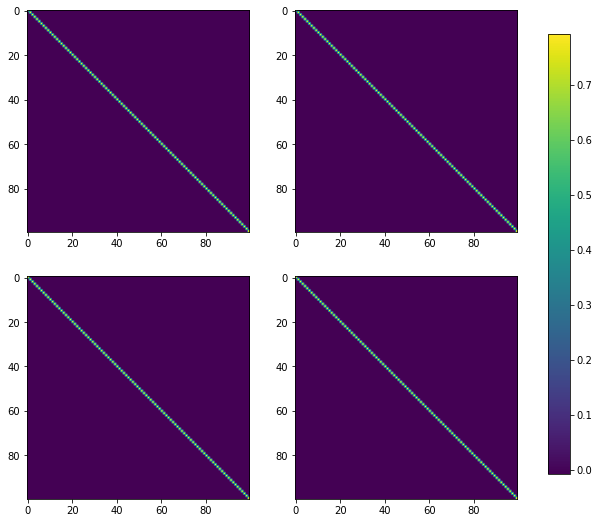

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (11,9))
i = 1
for ax in axs.flat:
    plt.sca(ax)
    plt.imshow(A_np[i], cmap='viridis')
    i += 1
plt.colorbar(ax=axs.ravel().tolist(), shrink=0.9)
plt.show()




How about matshow?



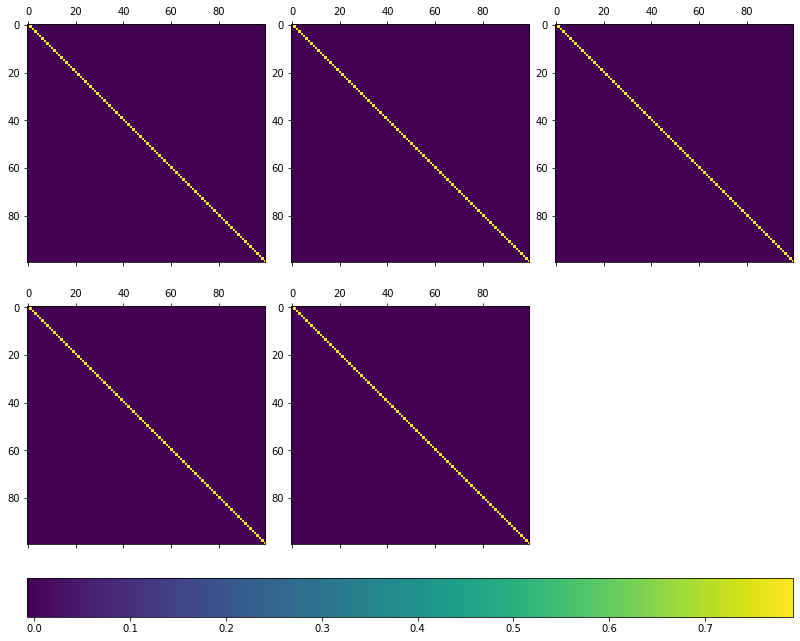

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (11,9), layout = 'constrained')
axes[-1,-1].axis('off')
for k in range(5):
    i = k // 3
    j = k - 3*i
    im = axes[i,j].matshow(A_np[k])

fig.colorbar(im, ax=axes.ravel().tolist(), norm = colors.Normalize(vmin = vmin, vmax = vmax), location = 'bottom')

plt.show()